<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Custom embedddings con Gensim



### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto. Se utilizará un cuento para generar los embeddings, es decir, que los vectores tendrán la forma en función de como el autor haya utilizado las palabras en su historia.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
from keras.preprocessing.text import text_to_word_sequence
from sklearn.manifold import TSNE

2022-11-05 16:04:19.159698: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

### Datos
Utilizaremos como dataset el cuento "The Evitable Conflict" de Isaac Asimov.

In [17]:
file = open("./the_evitable_conflict.txt", "r")

In [26]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('./the_evitable_conflict.txt', sep='/n', header=None)

/var/folders/v5/666psn050jv697dd4014yc000000gn/T/ipykernel_1526/2197729148.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('./the_evitable_conflict.txt', sep='/n', header=None)


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       261 non-null    object
dtypes: object(1)
memory usage: 2.2+ KB


In [33]:
df.head()

,0
0,"The Co-ordinator, in his private study, had th..."
1,"To be sure, the medieval man might not have re..."
2,"The quiet, licking flame lay in an insulated r..."
3,The logs were ignited at long distance through...
4,The same button that controlled the ignition f...


In [27]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 261


### 1 - Preprocesamiento

In [37]:
sentence_tokens = []
# Recorrer todas las filas y transformar las oraciones
# en una secuencia de palabras (esto podría realizarse con NLTK o spaCy también)
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [38]:
# Demos un vistazo
sentence_tokens[:2]

[['the',
  'co',
  'ordinator',
  'in',
  'his',
  'private',
  'study',
  'had',
  'that',
  'medieval',
  'curiosity',
  'a',
  'fireplace'],
 ['to',
  'be',
  'sure',
  'the',
  'medieval',
  'man',
  'might',
  'not',
  'have',
  'recognized',
  'it',
  'as',
  'such',
  'since',
  'it',
  'had',
  'no',
  'functional',
  'significance']]

### 2 - Crear los vectores (word2vec)

In [40]:
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobracargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [117]:
# Crearmos el modelo generador de vectores
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count=5,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=2,       # cant de palabras antes y desp de la predicha
                     vector_size=300,       # dimensionalidad de los vectores 
                     negative=20,    # cantidad de negative samples... 0 es no se usa
                     workers=1,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram

In [118]:
# Buildear el vocabularui con los tokens
w2v_model.build_vocab(sentence_tokens)

In [119]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 261


In [120]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de words distintas en el corpus: 284


### 3 - Entrenar el modelo generador

In [121]:
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=20,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 79190.7265625
Loss after epoch 1: 36491.203125
Loss after epoch 2: 36701.3984375
Loss after epoch 3: 36035.4375
Loss after epoch 4: 36755.890625
Loss after epoch 5: 36363.046875
Loss after epoch 6: 36137.359375
Loss after epoch 7: 36612.59375
Loss after epoch 8: 37037.53125
Loss after epoch 9: 36144.9375
Loss after epoch 10: 36731.59375
Loss after epoch 11: 36257.625
Loss after epoch 12: 35650.3125
Loss after epoch 13: 35864.09375
Loss after epoch 14: 36315.3125
Loss after epoch 15: 36937.375
Loss after epoch 16: 35828.125
Loss after epoch 17: 36763.5625
Loss after epoch 18: 36226.5
Loss after epoch 19: 36335.9375


(67003, 177500)

### 4 - Ensayar

In [122]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["susan"], topn=10)

[('dr', 0.9980614185333252),
 ('”', 0.9970981478691101),
 ('“i', 0.9970637559890747),
 ('said', 0.9969003200531006),
 ('silver', 0.9968336820602417),
 ('byerley', 0.9967759251594543),
 ('tell', 0.9966092109680176),
 ('“and', 0.996454119682312),
 ('“but', 0.9963146448135376),
 ('calvin', 0.9962874054908752)]

In [123]:
# Palabras que MAS se relacionan con...:
w2v_model.wv.most_similar(positive=["machines"], topn=20)

[('they', 0.9982225298881531),
 ('now', 0.9981389045715332),
 ('but', 0.9980581998825073),
 ('so', 0.9979608654975891),
 ('cannot', 0.9979175925254822),
 ('if', 0.9977623820304871),
 ('to', 0.9976966977119446),
 ('them', 0.9976716637611389),
 ('us', 0.9976332783699036),
 ('correct', 0.9975544214248657),
 ('are', 0.997525155544281),
 ('about', 0.9974929094314575),
 ('these', 0.9974923133850098),
 ('such', 0.9974843263626099),
 ('since', 0.9974430203437805),
 ('while', 0.9974412322044373),
 ('wrong', 0.9974253177642822),
 ('work', 0.9974128603935242),
 ('that', 0.9973974823951721),
 ('nothing', 0.9973897337913513)]

In [83]:
w2v_model.wv.most_similar(positive=["data"], topn=10)

[('fed', 0.9982240200042725),
 ('problem', 0.9980048537254333),
 ('human', 0.9979575276374817),
 ('part', 0.9978302717208862),
 ('wrong', 0.9978042840957642),
 ('answer', 0.9977549910545349),
 ('machine’s', 0.9976991415023804),
 ('so', 0.9976944923400879),
 ('because', 0.9976551532745361),
 ('any', 0.9976547956466675)]

In [62]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["production"], topn=10)

[('fire', 0.9993094801902771),
 ('system', 0.9992967247962952),
 ('people', 0.9992939233779907),
 ('economy', 0.9992900490760803),
 ('control', 0.9992871284484863),
 ('consider', 0.9992823004722595),
 ('itself', 0.9992749094963074),
 ('great', 0.9992518424987793),
 ('some', 0.9992495775222778),
 ('same', 0.9992481470108032)]

In [84]:
# Palabras que MÁS se relacionan con...:
w2v_model.wv.most_similar(positive=["society"], topn=15)

[('together', 0.999030590057373),
 ('some', 0.9989355802536011),
 ('follow', 0.9988798499107361),
 ('left', 0.9988763332366943),
 ('while', 0.9988641738891602),
 ('consider', 0.9988558292388916),
 ('civilization', 0.9988504648208618),
 ('people', 0.9988402724266052),
 ('made', 0.9988328218460083),
 ('end', 0.99880051612854),
 ('itself', 0.9987892508506775),
 ('come', 0.9987837076187134),
 ('machine’s', 0.9987834095954895),
 ('control', 0.9987744688987732),
 ('call', 0.9987645745277405)]

In [86]:
w2v_model.wv.most_similar(positive=["wars"], topn=20)

[('most', 0.9988884925842285),
 ('question', 0.9988718032836914),
 ('map', 0.9988349080085754),
 ('control', 0.9988088011741638),
 ('production', 0.9987959265708923),
 ('important', 0.9987919330596924),
 ('system', 0.9987732172012329),
 ('end', 0.9987587928771973),
 ('few', 0.9987534284591675),
 ('past', 0.998749315738678),
 ('economic', 0.998712420463562),
 ('some', 0.9987000226974487),
 ('non', 0.9986996650695801),
 ('“is', 0.9986870884895325),
 ('itself', 0.9986833333969116),
 ('even', 0.9986759424209595),
 ('far', 0.9986619353294373),
 ('consider', 0.9986519813537598),
 ('another', 0.9986478090286255),
 ('same', 0.9986429810523987)]

In [85]:
w2v_model.wv.most_similar(negative=["wars"], topn=20)

[('000', -0.5863093137741089),
 ('square', -0.7709922194480896),
 ('b—population', -0.7786872982978821),
 ('miles', -0.7877351641654968),
 ('a—area', -0.8322468996047974),
 ('c—capital', -0.8334433436393738),
 ('region', -0.9522632956504822),
 ('ordinator', -0.9601461887359619),
 ('co', -0.9663436412811279),
 ('land', -0.9849085807800293),
 ('you', -0.9893751740455627),
 ('said', -0.9903244376182556),
 ('susan', -0.9910814166069031),
 ('me', -0.9912799000740051),
 ('calvin', -0.9922041296958923),
 ('it', -0.9928881525993347),
 ('they', -0.9931951761245728),
 ('i', -0.993516206741333),
 ('northern', -0.9936097264289856),
 ('the', -0.9937112331390381)]

### 5 - Visualizar agrupación de vectores

In [72]:
def reduce_dimensions(model):
    num_dimensions = 2  

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

In [74]:
x_vals, y_vals, labels = reduce_dimensions(w2v_model)

MAX_WORDS=300
fig = px.scatter(x=x_vals[:MAX_WORDS], y=y_vals[:MAX_WORDS], text=labels[:MAX_WORDS])
#fig.show(renderer="colab") # esto para plotly en colab
fig.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



### 6- Conclusiones

Sinopsis del texto:
  
Las "máquinas" , potentes computadoras positrónicas que se utilizan para optimizar la economía mundial y la producción de alimentos, comienzan a dar instrucciones que parecen ir en contra de sus funciones. Aunque cada uno de estos problemas es insignificante, el mero hecho de que existan crear una gran alarma en el mundo Coordinador Stephen Byerley (ya apareció en la prueba). Así que decidió consultar a los otros cuatro coordinadores regionales (Regiones del Este, Tropical, Europea y del Norte respectivamente) para saber lo que pensaban, y finalmente decidió ponerse en contacto con el robo, la psicóloga Susan Calvin. Después de una larga charla, juntos descubren que las máquinas han generalizado la primera ley de la robótica al convertirla en "un robot no puede dañar a la humanidad, ni puede permitir, por su falta de intervención, que la humanidad reciba daño" (una anticipación a la ley Cero más tarde hipotetizada por R. Daneel Olivaw en robots y El Imperio). Al final de la historia, el Dr. Calvin concluye que las anomalías "son actos deliberados de máquinas, que les permiten perpetrar un pequeño daño a personas individuales seleccionadas para evitar un gran daño al futuro de toda la humanidad." De hecho, las Máquinas han tomado la decisión de que la única manera de seguir la Primera Ley es tomar el control de la humanidad, y que por ironía, es uno de los eventos que las Tres Leyes deberían prevenir de cualquier manera. Asimov volvió a este tema en El sol desnudo y los robots del amanecer, en el que la influencia y el control no es una conspiración limitada como la de las máquinas, sino que es la influencia que una multitud de robots logran aplicar sin saberlo en el desarrollo de la humanidad.

Fuente: https://es.wikipedia.org/wiki/El_conflicto_evitable

Para el topn de similitud entre palabras:
- Susan: es interesante ver cómo queda relacionada con la palabra Dr. y con su apellido Calvin, por la frecuencia en que aparecen juntas esas 3 palabras en la historia. Por otro lado, dado que su conversación es siempre con el Dr. Stephen Byerley; también tiene sentido que aparezcan en el top.
  
- Machines: se puede ver la relación con las palabras correct, work y wrong; que es un poco de lo que trata la historia, de si las maquinas estan funcionando correctamente o de forma subóptima.
  
- Data: en este caso trae las palabras fed (alimentar), problem, human, part, wrong y answer. También tiene sentido, gran parte de la historia es acerca de si los humanos estan alimentando con datos parciales o incorrectos a las máquinas, y estas pueden llegar a estar haciendo predicciones incorrectas.

- Production: trae palabras con las que se la puede asociar incluso fuera de este texto: system, people, economy y control.

- Society: trae palabras como civilization y people. Acá como dato interesante, no trajo la palabra humanity. En el texto hay una sociedad que se menciona múltiples veces: Society for Humanity.

- Wars: 
  - Al igual que Production, trae palabra que podemos asociar sin haber leído el texto: control, production, important, system, economic. Dentro del texto se menciona a las guerras como parte de la historia de la humanidad: Dynastic Wars (por el control de Europa), Religious Wars (Catolicos vs Protestantes) e Imperialist Wars (por el control económico). En este caso, solo trajo asociadas una de estas tres. 
  - Cuando buscamos por el negativo, trae palabras que se asocian al Co-ordinator (Stephen Byerley) y Susan Calvin.

Para el gráfico:
- "Cluster de personajes": La cercanía entre las palabras Dr, Susan, Calvin, Stephen y Byerley (los personajes que mantienen el diálogo) e incluso Dr Silver quien es mencionado en sus diálogos.
- "Cluster de regiones": La cercanía entre las palabras region, northern, eastern, tropic. Aquí queda un poco alejada la region Europea.
- "Cluster de economy": La cercanía entre las palabras people, economy, complicated, system

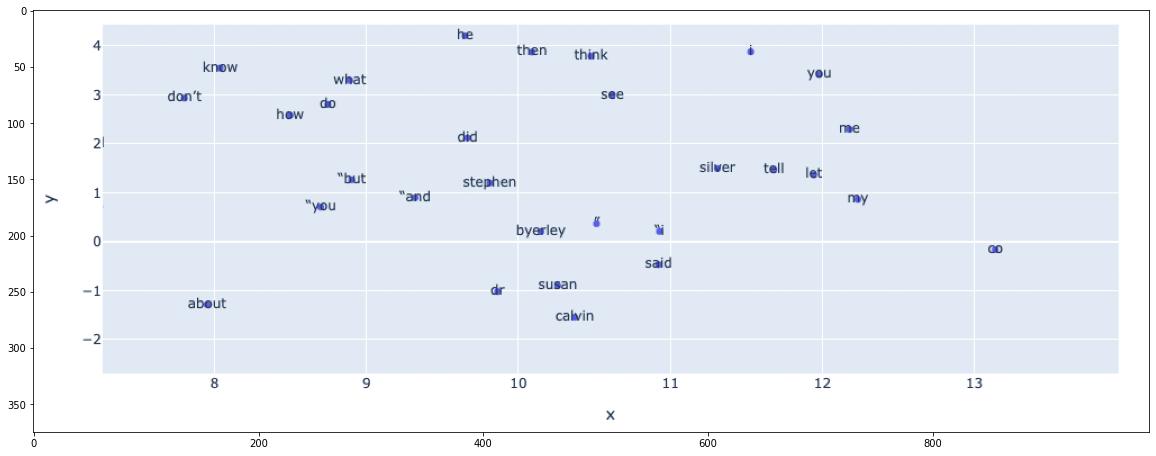

In [2]:
img1 = plt.imread('./img1.png')
plt.figure(figsize=(20,10))
plt.imshow(img1)

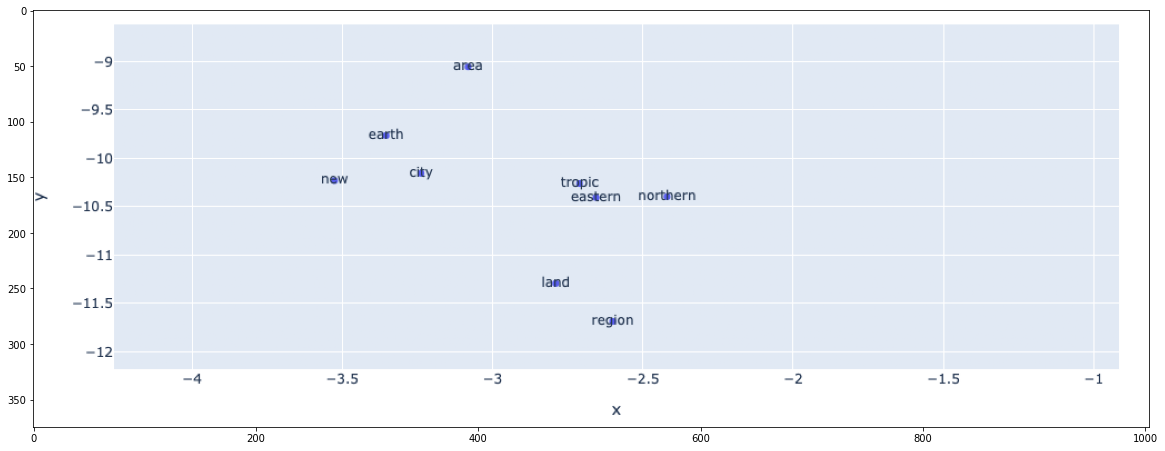

In [3]:
img2 = plt.imread('./img2.png')
plt.figure(figsize=(20,10))
plt.imshow(img2)

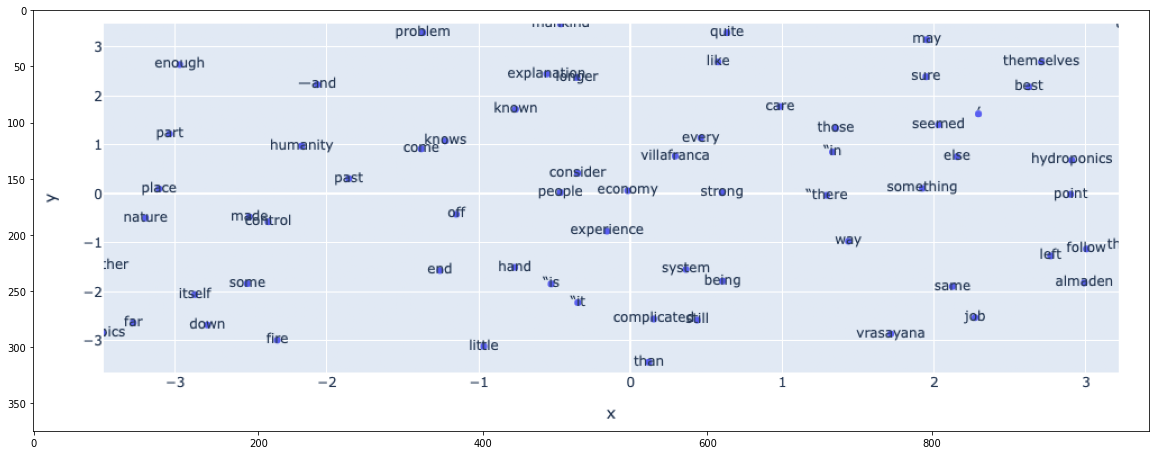

In [4]:
img3 = plt.imread('./img3.png')
plt.figure(figsize=(20,10))
plt.imshow(img3)